### Query ORCID for people affiliated with an organization and filter for current employees only

This notebook queries the [ORCID Public API](https://api.orcid.org/v3.0/) for all [people affiliated with an organization](https://info.orcid.org/faq/how-do-i-find-orcid-record-holders-at-my-institution/) and additionally narrows down the affiliation to people **currently employed** by the organization. From the resulting list of people we output the ORCID iDs.

*Disclosure:
The process of querying the ROR API for additional identifiers and using them to query the ORCID API for affiliated people is the same as used by the [FREYA PID Graph](https://blog.datacite.org/powering-the-pid-graph/) and is implemented in [DataCite Application API](https://doi.org/10.5438/8gb0-v673).*

In [1]:
# Prerequisites:
import requests                        # dependency to make HTTP calls
from benedict import benedict          # dependency for dealing with json

The input for this notebook is a ROR URL or ID, e.g. '`https://ror.org/04aj4c181`' or '`04aj4c181`'.

In [2]:
example_ror="https://ror.org/04aj4c181"

### Organization metadata
The first step is to call the [ROR API](https://ror.readme.io/) for the organization's metadata.

In [3]:
# URL to ROR API
ROR_API_ENDPOINT = "https://api.ror.org/organizations"

# query ROR API for organization's metadata
def query_ror_api(ror):
    complete_url=requests.utils.requote_uri(ROR_API_ENDPOINT + "/" + ror)
    response = requests.get(url=complete_url,
                      headers={'Accept': 'application/json'})
    response.raise_for_status()
    result=response.json()
    return result

#--- example execution
ror_data=query_ror_api(example_ror)
# if you want to see the retrieved metadata, uncomment next lines
#import pprint
#pprint.pprint(ror_data)

In particular we are interested in the organization's Grid ID and Wikidata ID.

In [4]:
def extract_grid_from_ror_data(ror_data):
    orga_dict = benedict.from_json(ror_data)
    path_to_grid_id = "external_ids.GRID.all"
    grid_id = orga_dict.get(path_to_grid_id)
    return grid_id

def extract_wikidata_from_ror_data(ror_data):
    orga_dict = benedict.from_json(ror_data)
    path_to_wikidata_id = "external_ids.Wikidata.all[0]"
    wikidata_id = orga_dict.get(path_to_wikidata_id)
    return wikidata_id


#--- example execution
organization_grid_id=extract_grid_from_ror_data(ror_data)
print("grid ID: " + str(organization_grid_id or ''))
organization_wikidata_id=extract_wikidata_from_ror_data(ror_data)
print("Wikidata ID: " + str(organization_wikidata_id or ''))

grid ID: grid.461819.3
Wikidata ID: Q2399120


We use the Wikidata ID of the organization to query Wikidata for the Ringgold ID of the organization.

In [5]:
WIKIDATA_API = "https://www.wikidata.org/w/api.php"

# query Wikidata with an organization's Wikidata ID
def query_wikidata_api(wikidata_id):
    response = requests.get(url=WIKIDATA_API,
                          params={'action': 'wbgetentities', 'ids': wikidata_id, 'props':'claims', 'format':'json'},
                          headers={'Accept': 'application/json'})
    response.raise_for_status()
    result=response.json()
    return result

def extract_ringgold_from_wikidata_data(wikidata, wikidata_id):
    wikidata_dict = benedict.from_json(wikidata)
    path_to_ringgold_id = f"entities.{wikidata_id}.claims.P3500[0].mainsnak.datavalue.value"
    ringgold_id = wikidata_dict.get(path_to_ringgold_id)
    return ringgold_id


#--- example execution
wikidata_data = query_wikidata_api(organization_wikidata_id)
organization_ringgold_id = extract_ringgold_from_wikidata_data(wikidata_data, organization_wikidata_id)
print("Ringgold ID: " + str(organization_ringgold_id or ''))

Ringgold ID: 28359


To sum up the process up until now:
1.   We used an organization's ROR ID to query the ROR API for an organization's Grid ID and Wikidata ID. 
2. We use Wikidata as intermediary to retrieve the Ringgold ID of the organization.

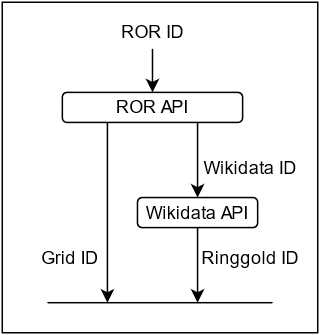

### Connection organization -> people
The second part of the process is to query for the people affiliated with the organization. For this we use the ORCID API and search for people affiliated with an organization like it is explained in the ORCID tutorial ["How do I find ORCID record holders at my institution?"](https://info.orcid.org/faq/how-do-i-find-orcid-record-holders-at-my-institution/). As parameters for the query we use the Grid ID and Ringgold ID for the organization.


In [6]:
# URL for ORCID search API
ORCID_SEARCH_API = "https://pub.orcid.org/v3.0/expanded-search/"

# query ORCID with an organization's Grid ID and Ringgold
def query_orcid_for_affiliations(grid_id, ringgold_id):
    query = f"grid-org-id:{grid_id}" if grid_id else ""
    query += " OR " if grid_id and ringgold_id else ""
    query += f"ringgold-org-id:{ringgold_id}" if ringgold_id else ""

    response = requests.get(url=ORCID_SEARCH_API,
                          params={'q': query},
                          headers={'Accept': 'application/json'})
    response.raise_for_status()
    result=response.json()
    return result

def extract_orcids_from_affiliated_people(affiliated_people):
    people_dict = benedict.from_json(affiliated_people)
    for person in people_dict.get('expanded-result'):
        orcid=benedict(person).get('orcid-id')
        given_name=benedict(person).get('given-names') 
        family_name=benedict(person).get('family-names')
        name = f"{given_name} {family_name}"
        yield orcid,name


#-- example execution
affiliated_people = query_orcid_for_affiliations(organization_grid_id, organization_ringgold_id)
affiliated_count = affiliated_people.get('num-found','')
print(f"Number of affiliated people: {affiliated_count}")

affiliated_orcids= extract_orcids_from_affiliated_people(affiliated_people)
for orcid,name in affiliated_orcids:
    print(f"{orcid}, {name}")

Number of affiliated people: 90
0000-0001-8258-2603, Noreen Krause
0000-0002-8913-9011, Sandra Mierz
0000-0002-2013-6920, Gazi Yücel
0000-0001-6836-1193, Marleen Burger
0000-0001-9924-9153, Allard Oelen
0000-0001-5232-9236, Sebastian Becker
0000-0003-3975-5374, Hassan Hussein
0000-0002-0687-5460, Britta Dreyer
0000-0001-8777-2780, Mohamad Yaser Jaradeh
0000-0003-2237-7725, Olga Lezhnina
0000-0003-3922-8638, Mathias Begoin
0000-0002-5610-9908, Evelyn Navarrete None
0000-0003-2749-7988, Clarissa Schnabel
0000-0001-9758-904X, Susanne Nicolai
0000-0003-2718-0913, Sven Strobel
0000-0002-2614-1253, Oleg Nekhayenko
0000-0002-1266-4029, Anke Tina Krüger
0000-0003-0929-7528, Markus Prinzhorn
0000-0002-4311-5620, Mitra Safaei
0000-0002-1595-3213, Philip Strömert
0000-0001-5135-5758, Katrin Leinweber
0000-0002-3680-2086, Jens Kösters
0000-0002-6347-5666, David Morris
0000-0002-2874-4832, Matti Stöhr
0000-0001-5375-3063, Nicola Bieg
0000-0003-1574-4865, Alexander Pöche
0000-0001-5322-0478, Judith 

### Filter for current employees
The connection between organization and people via their affiliation as defined by the ORCID API is quite abroad: 

*   It contains each person that used the organization identifier in one of the sections [employment, education & qualifications, membership & service, invited positions & distinctions](https://info.orcid.org/documentation/integration-guide/working-with-organization-identifiers/) in their ORCID record.
* Furthermore the connection is not limited to the current affiliation but also contains people that were affiliated with the organization years ago.

--> 

That's why we decided to use the ORCID iDs we retrieve via the search API to query the ORCID API for each of their detailed record to narrow the result set down to only people who 
* use one of the organization's IDs in the employment section
* and that are currently employed (end-date of employment is empty)

In [7]:
# URL for ORCID API
ORCID_RECORD_API = "https://pub.orcid.org/v3.0/"

# query ORCID for an ORCID record
def query_orcid_for_record(orcid_id):

    response = requests.get(url=requests.utils.requote_uri(ORCID_RECORD_API + orcid_id),
                          headers={'Accept': 'application/json'})
    response.raise_for_status()
    result=response.json()
    return result

# check if affiliated person is a current employee
def is_current_employee(orcid_id, grid_id, ringgold_id):
    # get orcid record
    orcid_record = query_orcid_for_record(orcid_id)

    #filter for current employees only
    record_dict = benedict.from_json(orcid_record)
    path_to_employments = "activities-summary.employments.affiliation-group"
    for employment in record_dict.get(path_to_employments):
        employment_dict = benedict(employment)
        path_to_orga_id = "summaries[0].employment-summary.organization.disambiguated-organization.disambiguated-organization-identifier"
        path_to_end_date = "summaries[0].employment-summary.end-date"

        orga_id = employment_dict.get(path_to_orga_id)
        end_date = employment_dict.get(path_to_end_date)

        return not end_date and (orga_id == grid_id or orga_id == ringgold_id)


#--- example execution
affiliated_orcids = extract_orcids_from_affiliated_people(affiliated_people)
employee_orcids = [t for t in affiliated_orcids if is_current_employee(t[0], organization_grid_id, organization_ringgold_id)]
employee_count = len(employee_orcids)
print(f"Number of current employees: {employee_count}")
for orcid,name in employee_orcids:
    print(f"{orcid}, {name}")

Number of current employees: 59
0000-0002-8913-9011, Sandra Mierz
0000-0002-2013-6920, Gazi Yücel
0000-0001-6836-1193, Marleen Burger
0000-0003-3975-5374, Hassan Hussein
0000-0003-3922-8638, Mathias Begoin
0000-0002-5610-9908, Evelyn Navarrete None
0000-0003-2749-7988, Clarissa Schnabel
0000-0001-9758-904X, Susanne Nicolai
0000-0003-2718-0913, Sven Strobel
0000-0002-2614-1253, Oleg Nekhayenko
0000-0003-0929-7528, Markus Prinzhorn
0000-0002-1595-3213, Philip Strömert
0000-0001-5135-5758, Katrin Leinweber
0000-0002-3680-2086, Jens Kösters
0000-0002-6347-5666, David Morris
0000-0002-2874-4832, Matti Stöhr
0000-0001-5375-3063, Nicola Bieg
0000-0003-1574-4865, Alexander Pöche
0000-0001-5322-0478, Judith Ludwig
0000-0002-1407-7362, Erhun Giray TUNCAY
0000-0002-6802-1241, Eric Müller-Budack
0000-0001-9248-5444, Junaid Ahmed Ghauri
0000-0002-0938-0340, Dana Vosberg
0000-0002-0698-2864, Sören Auer
0000-0003-2510-0529, Xenia van Edig
0000-0002-3060-7052, Felix Engel
0000-0002-2342-0636, Anja Mie

In [8]:
print(f"--> For this example we were able to narrow down the result from {affiliated_count} affiliated people to {employee_count} currently employed people.")

--> For this example we were able to narrow down the result from 90 affiliated people to 59 currently employed people.
